In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #serpara los datos 
from sklearn.metrics import confusion_matrix, classification_report #estos los regulatado las claisigfacion y la matriz de confusion
from sklearn.preprocessing import StandardScaler #normalizar los datos 


In [2]:

def to_classlabel(z):
    return z.argmax(axis = 1) #etiqeuta en la columna




In [3]:
#y susecion de numeros, 
def one_hot_encode(y):
    n_class = np.unique(y).shape[0] #cunatas clases tiene Y 
    y_encode = np.zeros((y.shape[0], n_class)) 
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode



In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc #presicion 



In [ ]:


class Softmax_Regression_GDX():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param  
        
    
    def _softmax(self, Z):

        shiftZ = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(shiftZ)
        return expZ / np.sum(expZ, axis=1, keepdims=True)



    #fiunciond e cosot binaria 
    def _loss(self, Y, h):
      
        epsilon = 1e-10  # Para evitar log(0)
        m = Y.shape[0]
    
        loss = -np.sum(Y * np.log(np.clip(h, epsilon, 1 - epsilon))) / m

        reg_term = (self.lambda_param / (2 * m)) * np.sum(self.theta[1:, :]**2)
        return loss + reg_term

    def fit(self, A, y, learning_rate=0.01, momentum=0.9, 
            lr_dec=0.5, lr_inc=1.05, max_perf_inc=1.04,
            epochs=100, batch_size=32, show_step=10, 
            stopping_threshold=1e-6, verbose=False):
        
        Y = one_hot_encode(y)
        n_classes = Y.shape[1]
        n_features = A.shape[1]
        
        self.theta = np.random.randn(n_features, n_classes) * 0.01
        delta_theta = np.zeros_like(self.theta)
        n_obs = A.shape[0]
        lr = learning_rate
        previous_loss = np.inf
        epoch_loss = []
        
        for e in range(epochs + 1):
            THETA_prev = self.theta.copy()
            loss_e = 0
            
            indices = np.random.permutation(n_obs)
            A_shuffled = A[indices]
            Y_shuffled = Y[indices]
            
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
            
            for batch_idx in range(total_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                if batch_idx == n_batches and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]

             
                Z_batch = A_batch @ self.theta
                S_batch = self._softmax(Z_batch)
                loss_batch = self._loss(Y_batch, S_batch)
                loss_e += loss_batch
        
                grad = (1 / len(A_batch)) * A_batch.T @ (S_batch - Y_batch)
                grad[1:, :] += (self.lambda_param / len(A_batch)) * self.theta[1:, :]
   
                delta_theta = momentum * delta_theta - (1 - momentum) * lr * grad
                self.theta += delta_theta
 
            avg_loss = loss_e / total_batches
            if avg_loss > previous_loss * max_perf_inc:
                self.theta = THETA_prev
                lr *= lr_dec
            elif avg_loss < previous_loss:
                lr *= lr_inc
            
            epoch_loss.append(avg_loss)
            
            if abs(previous_loss - avg_loss) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {e}")
                break
            
            previous_loss = avg_loss
            
            if verbose and e % show_step == 0:
                print(f'Epoch: {e}, Loss: {avg_loss:.3e}, lr: {lr:.2e}')
        
        return epoch_loss
                
    def predict_proba(self, A):
        Z = A @ self.theta
        return self._softmax(Z)






In [ ]:

class softMax_regresor_GDX_Multiclass():
    def __init__(self, lambda_param=0.01, num_classes=6):
        self.models = []
        self.losses = []
        self.lambda_param = lambda_param
        self.num_classes = num_classes
        
    def fit(self, A, y, **fit_params):
        self.models = []
        self.losses = []
        
        for i in range(self.num_classes):
            y_binary = np.where(y == i, 1, 0)
            
            positive_indices = np.where(y_binary == 1)[0]
            negative_indices = np.where(y_binary == 0)[0]
            
            n_pos = len(positive_indices)
            
            if n_pos > 0:
                neg_selected = np.random.choice(negative_indices, size=n_pos, replace=False)
                balanced_indices = np.concatenate([positive_indices, neg_selected])
                np.random.shuffle(balanced_indices)
                
                A_balanced = A[balanced_indices]
                y_balanced = y_binary[balanced_indices]
            else:
                print(f"Advertencia: Clase {i} tiene 0 muestras positivas")
                A_balanced = A
                y_balanced = y_binary
                
            model = Softmax_Regression_GDX(lambda_param=self.lambda_param)
            epoch_losses = model.fit(A_balanced, y_balanced, **fit_params)
            self.models.append(model)
            self.losses.append(epoch_losses)
    
    def predict_proba(self, A):
        probas = []
        for model in self.models:
            proba_matrix = model.predict_proba(A)  
            
            if proba_matrix.shape[1] == 2:
                proba_class_i = proba_matrix[:, 1]  
            else:
                proba_class_i = proba_matrix[:, 0]  
            probas.append(proba_class_i)
        return np.column_stack(probas)
    
    def predict(self, A):
        probas = self.predict_proba(A)
        return np.argmax(probas, axis=1)


In [7]:


# # Read the data
# data = np.loadtxt('admisiones_dataset.txt',delimiter=',')
# inputs = data[:,0:2]
# idx = 2-data[:,2] #restamos el 1 para establecer el categorico, adminitivos - 1 no admitivos - 0 
# targets = np.array(idx, dtype=int)     # codificacion categorica
# # targets = one_hot_encode(labels)      # one hot encode to classlabel


# Leer datos desde archivo dermatology.dat
# Reemplazar la sección de lectura de datos con:
try:
    # Leer el archivo .dat
    df = pd.read_csv('dermatology.dat', header=None, na_values='?', delimiter=r'\s+')
    
    # El dataset tiene 34 características + 1 columna de clase (35 columnas en total)
    # La última columna (columna 34) es la clase
    inputs = df.iloc[:, 0:34]
    targets = df.iloc[:, 34]
    
    # Manejar valores faltantes solo en la columna de edad (columna 33 - índice 33)
    age_mean = inputs[33].mean()
    inputs[33] = inputs[33].fillna(age_mean)
    
    # Convertir todo a tipo float
    inputs = inputs.astype(float)
    targets = targets.astype(int) - 1  # Convertir clases de [1-6] a [0-5]

except Exception as e:
    print(f"Error al leer el archivo: {e}")
    exit()


C:\Users\erikG\AppData\Local\Temp\ipykernel_13712\1964201352.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[33] = inputs[33].fillna(age_mean)


In [8]:

# Split the data
# x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234) # test_size genreta entrenamiento y prueba 

# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)


In [9]:
# Normalización
scaler = StandardScaler()
x_train_= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)



In [10]:
#matrices de disenio, 
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test = np.c_[np.ones(len(x_test)), x_test]



In [11]:

#online

# lambda_param = 0.01 

# fit_params = {
#     'learning_rate': 1e-3,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 1,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


# #minilonte
# lambda_param = 0.01  
# fit_params = {
#     'learning_rate': 0.01,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 64,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }

#lote

lambda_param = 0.01

fit_params = {
    'learning_rate': 1e-3,
    'momentum': 0.95,
    'lr_dec': 0.5,
    'lr_inc': 1.05,
    'max_perf_inc': 1.04,
    'epochs': 500,
    'batch_size': len(y_train),
    'show_step': 50,
    'stopping_threshold': 1e-6,
    'verbose': True
}

In [12]:


# # Build and fit best LR model
# alpha = 0.01 #lr
# maxEpochs = 5000
# batch = 10 #minilotes
# show = 500 #view

# # Build model
# log_model = Logistic_Regression()
# # Fit Model
# theta, batch_loss, epoch_loss = log_model.fit(A_train, y_train, learning_rate=alpha, 
#                                 epochs=maxEpochs, batch_size=batch, show_step = show, verbose=True)


#---------------------------------------
# Entrenamiento del modelo dermatology.dat
model = softMax_regresor_GDX_Multiclass(lambda_param=lambda_param, num_classes=6)
model.fit(A_train, y_train, **fit_params)


Epoch: 0, Loss: 7.202e-01, lr: 1.05e-03
Epoch: 50, Loss: 4.687e-01, lr: 9.91e-03
Epoch: 100, Loss: 9.827e-02, lr: 1.14e-01
Epoch: 150, Loss: 1.411e-02, lr: 1.30e+00
Epoch: 200, Loss: 1.859e-03, lr: 1.49e+01
Early stopping at epoch 247
Epoch: 0, Loss: 7.817e-01, lr: 1.05e-03
Epoch: 50, Loss: 6.187e-01, lr: 6.70e-03
Epoch: 100, Loss: 3.577e-01, lr: 7.69e-02
Early stopping at epoch 131
Epoch: 0, Loss: 7.024e-01, lr: 1.05e-03
Epoch: 50, Loss: 3.503e-01, lr: 1.20e-02
Epoch: 100, Loss: 4.566e-02, lr: 1.38e-01
Epoch: 150, Loss: 5.255e-03, lr: 1.58e+00
Epoch: 200, Loss: 8.009e-04, lr: 1.82e+01
Early stopping at epoch 234
Epoch: 0, Loss: 7.131e-01, lr: 1.05e-03
Epoch: 50, Loss: 6.017e-01, lr: 1.20e-02
Epoch: 100, Loss: 2.535e-01, lr: 1.38e-01
Early stopping at epoch 135
Epoch: 0, Loss: 7.183e-01, lr: 1.05e-03
Epoch: 50, Loss: 5.414e-01, lr: 8.99e-03
Epoch: 100, Loss: 1.353e-01, lr: 1.03e-01
Epoch: 150, Loss: 1.621e-02, lr: 1.18e+00
Epoch: 200, Loss: 2.554e-03, lr: 1.35e+01
Early stopping at epo

In [14]:


# Predicciones y evaluación
# Predicciones
train_pred = model.predict(A_train)
test_pred = model.predict(A_test)


In [15]:
print("rendimiento en entrenamiento (multiclase):")
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_train, train_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_train, train_pred))

rendimiento en entrenamiento (multiclase):
Accuracy: 0.9727

matriz de confusion:
[[69  2  0  1  0  0]
 [ 0 42  0  2  0  1]
 [ 0  0 53  0  0  0]
 [ 0  1  0 33  0  0]
 [ 0  0  0  0 36  0]
 [ 0  0  0  0  0 16]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        72
           1       0.93      0.93      0.93        45
           2       1.00      1.00      1.00        53
           3       0.92      0.97      0.94        34
           4       1.00      1.00      1.00        36
           5       0.94      1.00      0.97        16

    accuracy                           0.97       256
   macro avg       0.97      0.98      0.97       256
weighted avg       0.97      0.97      0.97       256



In [16]:
print("\nrendimiento en prueba (multiclase):")
print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_test, test_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_test, test_pred))



rendimiento en prueba (multiclase):
Accuracy: 0.9636

matriz de confusion:
[[39  0  0  0  0  1]
 [ 0 15  0  1  0  0]
 [ 0  0 19  0  0  0]
 [ 0  1  0 13  1  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0  4]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.94      0.94      0.94        16
           2       1.00      1.00      1.00        19
           3       0.93      0.87      0.90        15
           4       0.94      1.00      0.97        16
           5       0.80      1.00      0.89         4

    accuracy                           0.96       110
   macro avg       0.93      0.96      0.95       110
weighted avg       0.97      0.96      0.96       110



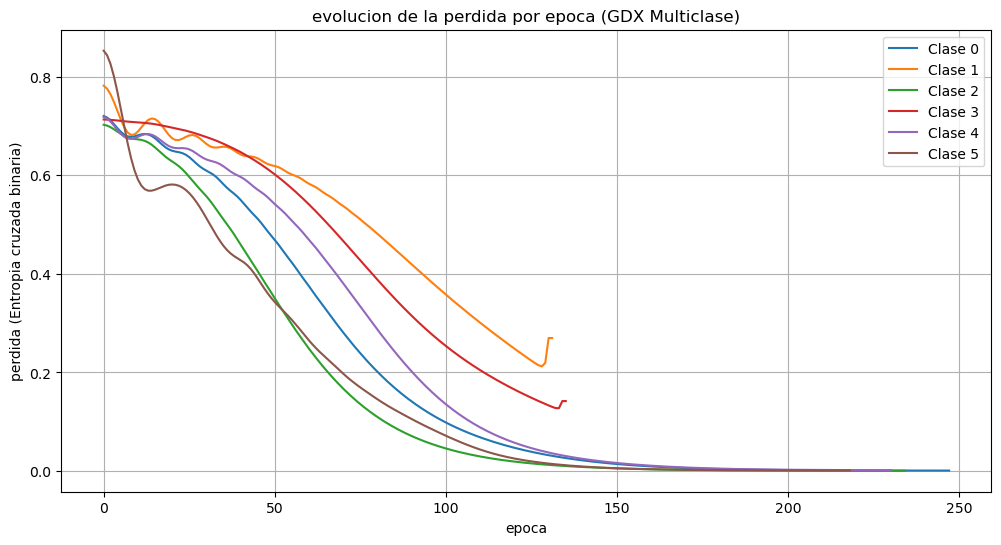

In [17]:
# Gráfica de pérdida
# Gráfica de pérdida
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epoch_loss, 'b-', linewidth=2)  
# plt.title('Evolución de la Pérdida por Época')
# plt.xlabel('Época')
# plt.ylabel('Pérdida (Entropía Cruzada)')
# plt.grid(True)


plt.figure(figsize=(12, 6))
for i, loss_list in enumerate(model.losses):
    plt.plot(loss_list, label=f'Clase {i}')
plt.title('evolucion de la perdida por epoca (GDX Multiclase)')
plt.xlabel('epoca')
plt.ylabel('perdida (Entropia cruzada binaria)')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
# 